In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from glob import glob
import seaborn as sns
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


# Size default
SIZE = 32

# Loading dataset

In [2]:
# read the training dataset
train = pd.read_csv('data_labels_mainData.csv')

# display the first 5 rows
train.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


Text(0.5, 1.0, 'isCancerous')

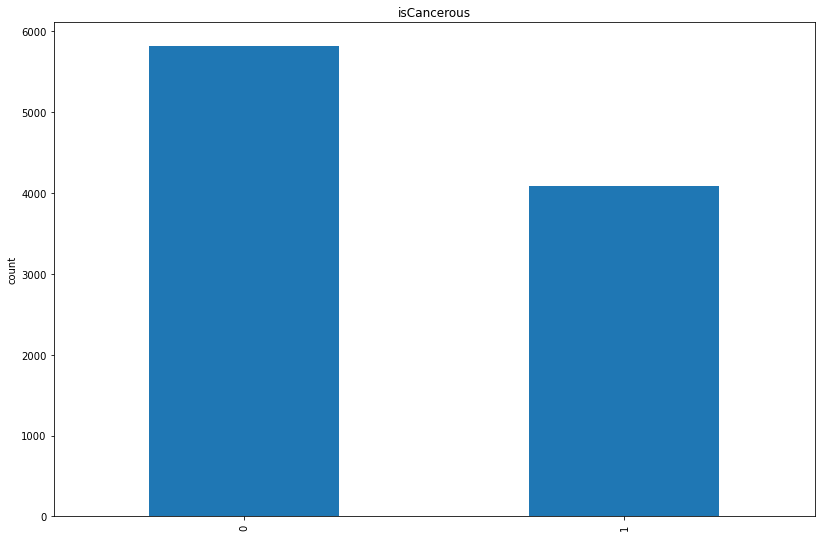

In [3]:
# Plot the datagram represent the number of data of cancerous and non-cancerous 
fig = plt.figure(figsize=(30,20))
ax1=fig.add_subplot(221)
train['isCancerous'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('count')
ax1.set_title('isCancerous')

In [4]:
# count value of 2 classes
train.isCancerous.value_counts()

0    5817
1    4079
Name: isCancerous, dtype: int64

# Data Preparation and Processing

In [5]:
# define new dataframe to store data of each class
train_0 = train[train['isCancerous'] == 0]
train_1 = train[train['isCancerous'] == 1]

In [6]:
# set the number of data of class 1 = number of data of class 0 (balance data)
train_1_balanced = resample(train_1, replace=True, n_samples = len(train_0), random_state = 42)

In [7]:
# combine back to a single dataframe
train_balanced = pd.concat([train_0,train_1_balanced])

In [8]:
# check the distribution: 2 classes should be balanced 
print(train_balanced['isCancerous'].value_counts())

1    5817
0    5817
Name: isCancerous, dtype: int64


In [9]:
# shape of dataframe
train_balanced.shape

(11634, 6)

In [10]:
# display the first 5 rows of the new dataframe
train_balanced.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [11]:
# drop unused columns
train_balanced = train_balanced.drop(['InstanceID', 'patientID',"cellTypeName","cellType"], axis = 1)

In [12]:
# dataframe after dropping column
train_balanced.head()

,ImageName,isCancerous
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


In [13]:
# read images based on ImageName from CSV file
path = "patch_images/"

# define the path and add as a new column 
train_balanced['path'] = path + train_balanced['ImageName']

# check the dataframe
train_balanced.head()

,ImageName,isCancerous,path
0,22405.png,0,patch_images/22405.png
1,22406.png,0,patch_images/22406.png
2,22407.png,0,patch_images/22407.png
3,22408.png,0,patch_images/22408.png
4,22409.png,0,patch_images/22409.png


In [14]:
# Use the path to read image and convert image into numpy array
train_balanced['image'] = train_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [15]:
# check dataframe
train_balanced

,ImageName,isCancerous,path,image
0,22405.png,0,patch_images/22405.png,"[[[242, 213, 237], [240, 210, 234], [236, 206,..."
1,22406.png,0,patch_images/22406.png,"[[[222, 176, 212], [224, 175, 211], [230, 181,..."
2,22407.png,0,patch_images/22407.png,"[[[247, 243, 247], [248, 242, 246], [248, 240,..."
3,22408.png,0,patch_images/22408.png,"[[[243, 242, 242], [243, 241, 241], [243, 241,..."
4,22409.png,0,patch_images/22409.png,"[[[188, 129, 188], [187, 127, 185], [186, 126,..."
...,...,...,...,...
6865,4043.png,1,patch_images/4043.png,"[[[164, 114, 183], [181, 134, 201], [215, 170,..."
2353,3066.png,1,patch_images/3066.png,"[[[95, 60, 161], [134, 100, 190], [190, 158, 2..."
6492,8264.png,1,patch_images/8264.png,"[[[211, 176, 225], [190, 147, 207], [193, 150,..."
2905,8830.png,1,patch_images/8830.png,"[[[246, 244, 244], [245, 243, 242], [252, 248,..."


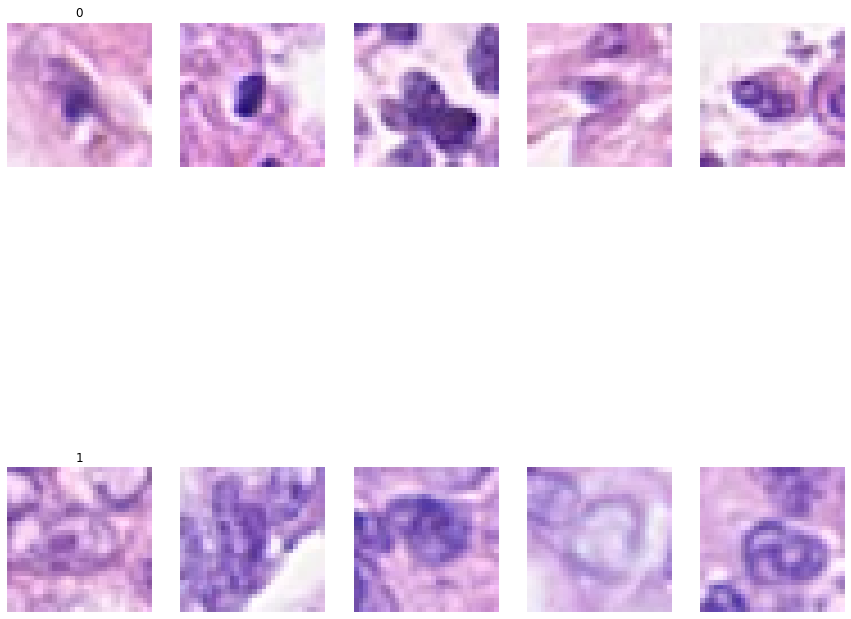

In [31]:
# Plotting some images of each class
fig, m_axs = plt.subplots(2, 5, figsize = (15, 15))
for n_axs, (type_name, type_rows) in zip(m_axs, train_balanced.sort_values(['isCancerous']).groupby('isCancerous')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Extract Training Data using Train_Split_Test


In [16]:
# X is value of images numpy array
X = np.asarray(train_balanced['image'].tolist())

# Scale values to 0:1
X = X/255.

print(X)

[[[[0.94901961 0.83529412 0.92941176]
   [0.94117647 0.82352941 0.91764706]
   [0.9254902  0.80784314 0.90196078]
   ...
   [0.92156863 0.76470588 0.89019608]
   [0.92941176 0.76862745 0.89803922]
   [0.92941176 0.76470588 0.89803922]]

  [[0.91372549 0.79215686 0.88627451]
   [0.90196078 0.78431373 0.87843137]
   [0.89803922 0.77647059 0.87058824]
   ...
   [0.94117647 0.77647059 0.90980392]
   [0.94901961 0.78431373 0.91372549]
   [0.90588235 0.74117647 0.8745098 ]]

  [[0.89019608 0.76470588 0.86666667]
   [0.8627451  0.7372549  0.84313725]
   [0.8627451  0.7372549  0.84313725]
   ...
   [0.94117647 0.77647059 0.91372549]
   [0.92941176 0.76078431 0.90196078]
   [0.89019608 0.72156863 0.85882353]]

  ...

  [[0.93333333 0.76078431 0.90588235]
   [0.85882353 0.69019608 0.83529412]
   [0.83529412 0.6627451  0.81568627]
   ...
   [0.83137255 0.64705882 0.83137255]
   [0.77647059 0.59215686 0.77647059]
   [0.81960784 0.64313725 0.82352941]]

  [[0.96078431 0.78431373 0.92941176]
   [0.8

In [17]:
# check the shape of X
X.shape

(11634, 32, 32, 3)

In [18]:
# reshape X
X = X.reshape((11634, 32*32*3))

In [19]:
# check the shape of X after reshape
X.shape

(11634, 3072)

In [21]:
# Assign the label values to Y
Y = train_balanced['isCancerous']

In [32]:
# Split data 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_train shape", y_test.shape)

X_train shape (9307, 3072)
y_train shape (9307,)
X_test shape (2327, 3072)
y_train shape (2327,)


# Build K-nearest neighbors Model and Training model

In [24]:
# Create KNeighbors
knn_cf = KNeighborsClassifier()

# Start training
knn_cf.fit(x_train, y_train)

# Prediction
y_pred = knn_cf.predict(x_test)

# Get Training accuracy score
print("Training Accuracy is :", knn_cf.score(x_train, y_train)*100)

# Get Testing accuracy score
print("Testing Accuracy is :", knn_cf.score(x_test, y_test)*100)

# print out classification report
print(classification_report(y_test, y_pred))

# Calcuate F1 score
print("F1 score is:", f1_score(y_pred, y_test))

# print confusion matrix
print(confusion_matrix(y_test, y_pred))

Training Accuracy is : 86.98828838508649
Testing Accuracy is : 82.38074774387624
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1197
           1       0.77      0.90      0.83      1130

    accuracy                           0.82      2327
   macro avg       0.83      0.83      0.82      2327
weighted avg       0.83      0.82      0.82      2327

F1 score is: 0.8325163398692811
[[ 898  299]
 [ 111 1019]]
